In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import scipy.stats as stats
from scipy.stats import shapiro, pearsonr
from itertools import combinations
import statsmodels.api as sm

plt.rcParams['font.family'] = 'AppleGothic'
plt.rc('axes',unicode_minus=False)

In [205]:
df = pd.read_csv('../datasets/all_data_resampled_train_data.csv')

In [206]:
df.columns

Index(['회사명', '거래소코드', '회계년도', 'CASH FLOW 대 부채비율', 'CASH FLOW 대 차입금비율',
       'CASH FLOW 대 총자본비율', 'CASH FLOW 대 매출액비율', '유동비율', '당좌비율', '부채비율',
       '유동부채비율', '차입금의존도', '순운전자본비율', '현금비율', '유동자산구성비율', '자기자본구성비율',
       '자기자본순이익률', '경영자본순이익률', '매출액순이익률', '총자본사업이익률', '총자본영업이익률', '매출액영업이익률',
       '금융비용부담률', 'CROE', '총자산증가율', '총자본증가율', '유동자산증가율', '비유동자산증가율', '매출액증가율',
       '유형자산증가율', '부가가치(백만원)', '총자본투자효율', '설비투자효율', '부가가치율', '이윤분배율', '자본분배율',
       '총자산회전율', '매출채권회전률', '당좌자산회전률', '유형자산회전율', '경영자본회전률', '총자본회전률',
       '비유동자산회전률', '유동자산회전률', '영업년수', '쭈피처', '영업레버리지', '재무레버리지', '영업투자현금비율',
       '영업재무현금비율', '도입기', '성숙기', '성장기', '쇠퇴기', '부실판단'],
      dtype='object')

In [207]:
df = df.drop(columns=['회사명', '거래소코드', '회계년도', '도입기', '성숙기', '성장기', '쇠퇴기', '영업레버리지', '재무레버리지'])

In [208]:
# H가 1인 경우 이분산성 / H가 0인 경우 등분산
from scipy.stats import bartlett
def bartlett_test(col, p_value = 0.05, H = 1):
    list= []
    for i in col:
        T, p_val = bartlett(df[df['부실판단']==1][i], df[df['부실판단']==0][i]) 
        list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    if H == 1:
        a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
        return a
    else:
        a = list[(list['p_value'] >= p_value)][['변수', 'p_value']].sort_values('p_value')
        return a

In [209]:
# 이분산성 변수
x_hetero = bartlett_test(df.columns, H = 1)
# 등분산성 변수
x_homo = bartlett_test(df.columns, H = 0)

In [210]:
# t-test

import scipy.stats as stats
def t_test(col, col_h0, col_h1, p_value = 0.05):
    list= []
    for i in col:
        if (col_h0['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(df[df['부실판단']==1][i], df[df['부실판단']==0][i], equal_var=True) # 등분산성 : wald t-test
            list.append([i, p_val])
        elif (col_h1['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(df[df['부실판단']==1][i], df[df['부실판단']==0][i], equal_var=False) # 이분산성 : welch’s t-test
            list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
    return a

In [211]:
# 2) t_test 결과 p_value < 0.05보다 작은 유의한 변수 가져오기
x_ttest = t_test(df.columns, x_homo, x_hetero, p_value=0.05)
print("유의한 피쳐 수 :", len(x_ttest))
x_ttest = x_ttest.sort_values(by="변수", ascending=True).reset_index(drop=True)
x_ttest

유의한 피쳐 수 : 34


,변수,p_value
0,CASH FLOW 대 매출액비율,4.352326e-40
1,CASH FLOW 대 부채비율,3.242145e-48
2,CASH FLOW 대 차입금비율,1.284830e-11
3,CASH FLOW 대 총자본비율,9.419825e-109
4,경영자본순이익률,1.923908e-118
5,경영자본회전률,3.549084e-73
6,금융비용부담률,2.725378e-59
7,당좌비율,3.734447e-13
8,당좌자산회전률,4.833668e-03
9,매출액순이익률,2.978902e-13


In [212]:
ttest_list = list(x_ttest['변수'])

In [213]:
ttest_df = df[ttest_list]

In [214]:
ttest_df

,CASH FLOW 대 매출액비율,CASH FLOW 대 부채비율,CASH FLOW 대 차입금비율,CASH FLOW 대 총자본비율,경영자본순이익률,경영자본회전률,금융비용부담률,당좌비율,당좌자산회전률,매출액순이익률,...,자기자본순이익률,자본분배율,쭈피처,차입금의존도,총자본사업이익률,총자본영업이익률,총자본투자효율,총자본회전률,총자산회전율,현금비율
0,-6.0000,-6.00,-10.0000,-3.00,5.00,1.00,0.74,174.00,1.00,8.56,...,9.77,53.000,0.153646,30.00,2.32,1.79,13.00,1.00,0.528874,30.00
1,4.0000,24.58,73.0000,4.00,1.44,1.00,-0.22,331.00,2.00,1.31,...,1.60,13.000,0.291623,5.00,1.44,1.14,25.00,1.00,1.020520,128.00
2,-8.0000,-5.00,-6.0000,-3.00,-12.64,1.00,5.12,164.00,2.00,-16.06,...,-3.74,-34.000,0.276756,55.00,-5.60,-5.71,10.00,0.00,0.455346,60.00
3,3.0000,3.00,7.0000,1.00,8.17,1.00,0.20,124.00,1.00,7.93,...,7.83,34.000,0.107574,23.00,5.33,4.78,19.00,1.00,0.528746,30.00
4,-1.0000,-3.00,-8.0000,-1.00,-4.80,1.00,-0.64,278.00,1.00,-8.45,...,-5.30,-231.000,0.118425,7.00,-3.29,-3.78,2.00,1.00,0.484265,71.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8953,-210.8200,-3.30,-3.3400,-2.86,-3.29,0.01,227.39,50.61,0.04,-246.10,...,-22.29,0.000,1.204336,85.56,0.80,-0.27,0.29,0.01,0.013561,0.15
8954,-2904.0041,-47.84,-84.4700,-47.38,-1.76,0.01,120.88,618.04,0.01,-255.04,...,-75.59,-1228.314,2.729826,56.09,-0.20,-1.16,0.00,0.01,0.004619,11.81
8955,-170.6100,-9.79,-11.2500,-10.42,-6.08,0.05,70.36,4.73,7.85,-119.10,...,0.00,88.570,0.420746,92.60,-13.55,-13.56,12.23,0.05,0.061049,1.28
8956,-1.7700,-14.81,0.0000,-4.80,1.93,4.03,-0.18,209.54,4.14,0.48,...,1.93,10.710,0.067146,0.00,2.41,1.91,16.18,2.76,2.716650,37.99


### Wrapper 피처 셀렉션

In [215]:
wrapper_df = df

In [216]:
# 학습 데이터와 검증 데이터 분리
X_train = wrapper_df.drop(columns='부실판단')
y_train = wrapper_df['부실판단']

#### 스케일링

In [217]:
labels = X_train.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data=X_train, columns = labels)

In [218]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [219]:
sbs = SFS(LinearRegression(),
         k_features=(5,15),
         forward=False,
         floating=False,
         cv=0)
sbs.fit(X_train, y_train)
li_backward_feature_list = sbs.k_feature_names_

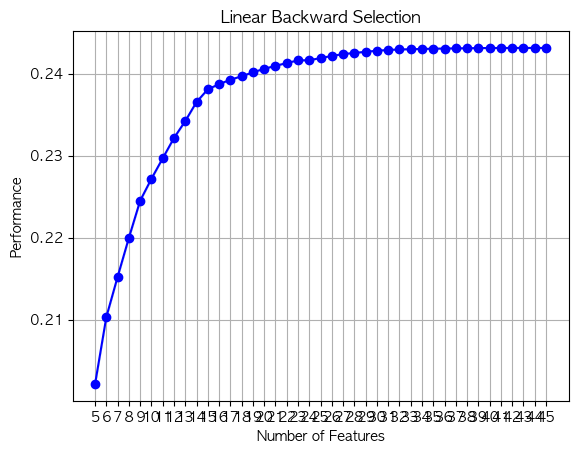

In [220]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('Linear Backward Selection')
plt.grid()
plt.show()

In [221]:
li_backward_feature = list(li_backward_feature_list)
li_backward_feature_final_list = li_backward_feature[0:15]

In [222]:
#Sequential backward selection(sbs)
sbs = SFS(LogisticRegression(),
         k_features=(5,15),
         forward=False,
         floating=False,
         cv=0)
sbs.fit(X_train, y_train)
logit_backward_feature_list = sbs.k_feature_names_


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

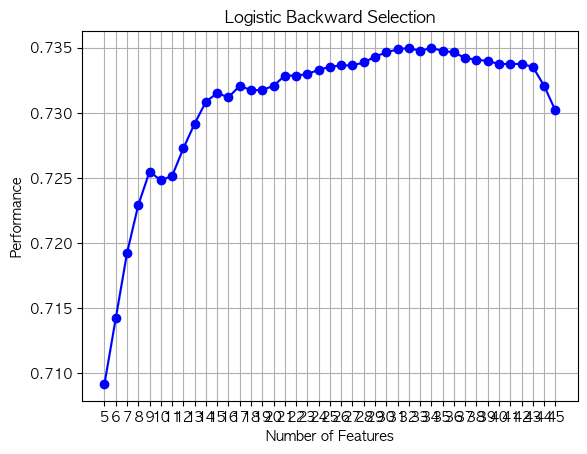

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('Logistic Backward Selection')
plt.grid()
plt.show()

In [ ]:
logit_backward_feature = list(logit_backward_feature_list)
logit_backward_feature_final_list = logit_backward_feature[0:13]

In [ ]:
#Sequential backward selection(sbs)
sbs = SFS(RandomForestClassifier(max_depth=5),
         k_features=(5,15),
         forward=False,
         floating=False,
         cv=0)
sbs.fit(X_train, y_train)
RF_backward_feature_list = sbs.k_feature_names_


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

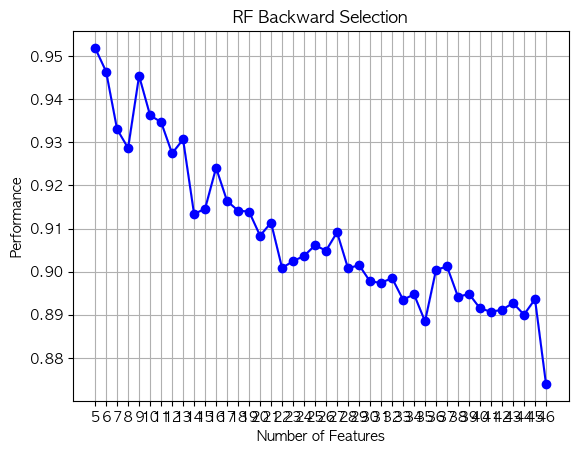

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('RF Backward Selection')
plt.grid()
plt.show()

In [ ]:
RF_backward_feature = list(RF_backward_feature_list)
RF_backward_feature_final_list = RF_backward_feature[0:12]

In [ ]:
def func_Linear_Backward(x):
    if x in li_backward_feature_final_list:
        return 1
    else:
        return 0

def func_Logit_Backward(x):
    if x in logit_backward_feature_final_list:
        return 1
    else:
        return 0
    
def func_RF_Backward(x):
    if x in RF_backward_feature_final_list:
        return 1
    else:
        return 0

In [ ]:
list_col_all = X_train.columns

# 중복 선택된 Feature
feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['Linear Backward'] = list_col_all.map(func_Linear_Backward)
feature_counts['Logit Backward'] = list_col_all.map(func_Logit_Backward)
feature_counts['RF Backward'] = list_col_all.map(func_RF_Backward)

feature_counts["Backward Total"] = feature_counts['Linear Backward'] + feature_counts['Logit Backward'] + feature_counts['RF Backward']

backward_feature_final = feature_counts[feature_counts["Backward Total"]>=2]
list_feature_final = list(backward_feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
backward_feature_final

선택된 피쳐수 : 5


,Feature,Linear Backward,Logit Backward,RF Backward,Backward Total
0,Unnamed: 0,1,1,1,3
2,CASH FLOW 대 차입금비율,1,1,1,3
10,순운전자본비율,1,1,1,3
18,총자본영업이익률,1,1,1,3
23,총자본증가율,1,1,1,3


In [ ]:
backward_feature = list(backward_feature_final['Feature'])
backward_feature

['Unnamed: 0',
 'CASH FLOW 대 차입금비율',
 'CASH FLOW 대 총자본비율',
 'CASH FLOW 대 매출액비율',
 '차입금의존도',
 '순운전자본비율',
 '유동자산구성비율',
 '자기자본구성비율',
 '경영자본순이익률',
 '총자본영업이익률',
 '금융비용부담률',
 '총자본증가율',
 '매출액증가율',
 '총자본투자효율',
 '이윤분배율',
 '총자산회전율',
 '유형자산회전율',
 '총자본회전률',
 '영업년수']

### Embedded : Lasso

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha= 0.02, max_iter = 10000).fit(X_train, y_train)
feature_list = lasso.feature_names_in_[lasso.coef_ != 0]

lasso_feature_list = feature_list
len(lasso_feature_list)

20

### Ttest, Backward, Lasso 중첩 feature 확인

In [ ]:
def func_Ttest(x):
    if x in ttest_list:
        return 1
    else:
        return 0
    
def func_Backward(x):
    if x in backward_feature:
        return 1
    else:
        return 0
    
def func_lasso(x):
    if x in lasso_feature_list:
        return 1
    else:
        return 0

In [ ]:
list_col_all = X_train.columns

# 중복 선택된 Feature
feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['Ttest'] = list_col_all.map(func_Ttest)
feature_counts['Backward'] = list_col_all.map(func_Backward)
feature_counts['Lasso'] = list_col_all.map(func_lasso)

feature_counts["Total"] = feature_counts["Ttest"]+feature_counts['Backward']+feature_counts["Lasso"]

feature_final = feature_counts[feature_counts["Total"]>=2]
list_feature_final = list(feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
feature_final

선택된 피쳐수 : 19


,Feature,Ttest,Backward,Lasso,Total
0,Unnamed: 0,1,1,1,3
2,CASH FLOW 대 차입금비율,1,1,0,2
3,CASH FLOW 대 총자본비율,1,0,1,2
4,CASH FLOW 대 매출액비율,1,0,1,2
9,차입금의존도,1,0,1,2
10,순운전자본비율,1,1,1,3
12,유동자산구성비율,1,0,1,2
13,자기자본구성비율,1,0,1,2
15,경영자본순이익률,1,0,1,2
18,총자본영업이익률,1,1,1,3
